In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, StratifiedKFold


In [8]:

# Set plotting style
sns.set(style="whitegrid")

# Helper function to parse income
def parse_income(value):
    if pd.isna(value):
        return np.nan
    value = value.replace(",", "").replace("+", "")
    if "-" in value:
        low, high = map(int, value.split("-"))
        return (low + high) / 2
    return int(value)


In [13]:

# Load dataset
df = pd.read_csv(r"datasets/pd copy.csv")

# Combine sublocality and locality to form full neighborhood name
df['Neighborhood'] = df['Sublocality'].str.strip() + ", " + df['Neighborhood'].str.strip()

# Parse and clean income data
df['Income_Estimate'] = df['General Income (INR)'].apply(parse_income)
df = df.dropna(subset=['Income_Estimate'])

# Feature Engineering: Liveliness Score
df['Liveliness_Score'] = (
    df['Schools Nearby'].fillna(0) +
    df['Hospitals Nearby'].fillna(0) +
    df['Public Transport'].map({'Good': 3, 'Moderate': 2, 'Poor': 1}).fillna(0) +
    df['Community Sentiment'].map({'Positive': 3, 'Neutral': 2, 'Negative': 1}).fillna(0)
)


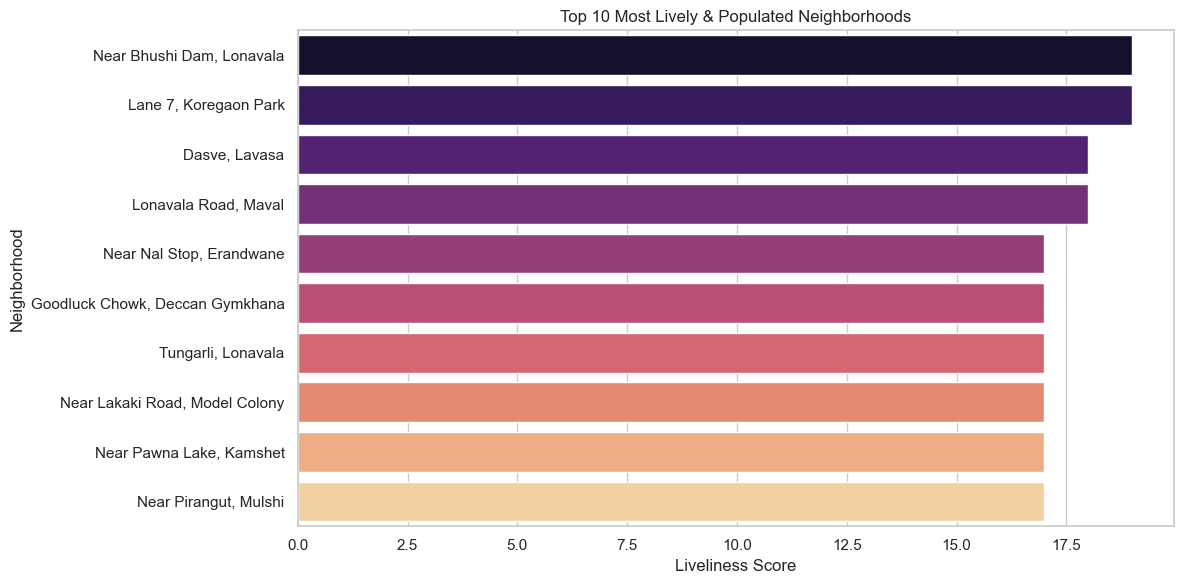

In [14]:

# Top 10 Lively Neighborhoods based on amenities and sentiment
lively_df = df.groupby('Neighborhood')['Liveliness_Score'].mean().sort_values(ascending=False).head(10)

# Plot the liveliness
plt.figure(figsize=(12, 6))
sns.barplot(x=lively_df.values, y=lively_df.index, palette="magma")
plt.title("Top 10 Most Lively & Populated Neighborhoods")
plt.xlabel("Liveliness Score")
plt.ylabel("Neighborhood")
plt.tight_layout()
plt.show()


In [15]:

# Define features for modeling
input_features = ['Professions', 'Income_Estimate', 'Community Sentiment', 'Public Transport']
categorical_features = ['Professions', 'Community Sentiment', 'Public Transport']
numerical_features = ['Income_Estimate']

# Preprocessing Pipelines
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Combine into full preprocessor
preprocessor = ColumnTransformer([
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
])


Silhouette Score (KMeans Clustering): 0.308


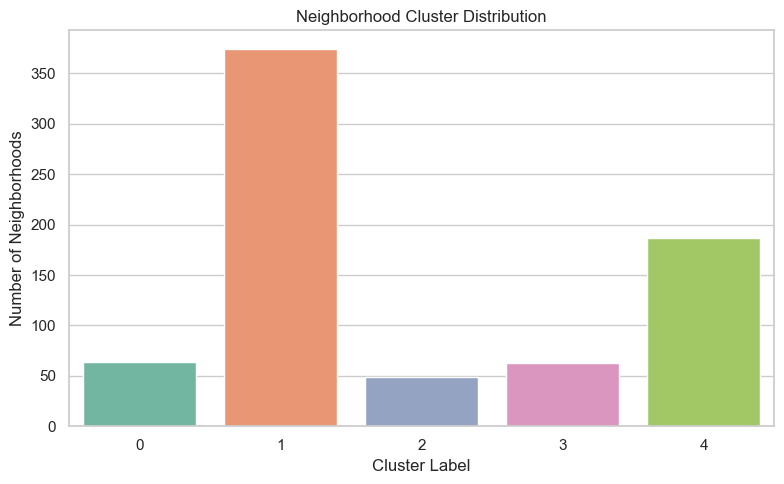

In [16]:

# Apply preprocessing
X_processed = preprocessor.fit_transform(df[input_features])

# KMeans Clustering
kmeans = KMeans(n_clusters=5, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_processed)
silhouette = silhouette_score(X_processed, cluster_labels)

print(f"Silhouette Score (KMeans Clustering): {silhouette:.3f}")

# Plot cluster distribution
df['Cluster'] = cluster_labels
plt.figure(figsize=(8, 5))
sns.countplot(x='Cluster', data=df, palette="Set2")
plt.title("Neighborhood Cluster Distribution")
plt.xlabel("Cluster Label")
plt.ylabel("Number of Neighborhoods")
plt.tight_layout()
plt.show()


In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline

# Filter data for valid crime rate categories
df_valid = df[df['Crime Rate'].isin(['Low', 'Moderate'])].copy()

# Check distribution of classes
class_counts = df_valid['Crime Rate'].value_counts()
print("Crime Rate Class Distribution:\n", class_counts)

# Ensure at least two classes exist for classification
if class_counts.nunique() < 2:
    print("Insufficient class diversity: classification requires at least two distinct classes.")
else:
    # Encode target labels
    label_encoder = LabelEncoder()
    df_valid['Crime_Encoded'] = label_encoder.fit_transform(df_valid['Crime Rate'])

    # Define classification pipeline
    clf_pipeline = make_pipeline(preprocessor, LogisticRegression(max_iter=1000))

    # Set up Stratified K-Fold cross-validation
    stratified_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Perform cross-validation and compute accuracy
    cv_scores = cross_val_score(
        clf_pipeline,
        df_valid[input_features],
        df_valid['Crime_Encoded'],
        cv=stratified_cv,
        scoring='accuracy'
    )

    # Display results
    print(f"Logistic Regression Accuracy (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")


Crime Rate Class Distribution:
 Crime Rate
Moderate    375
Low         362
Name: count, dtype: int64
Logistic Regression Accuracy (mean ± std): 0.947 ± 0.018
